In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import c

import pickle

# Import Pickle Dictionary

In [2]:
with open("GPS_fit_results.pkl", "rb") as f:
    dict_fit = pickle.load(f)

data_names = dict_fit["values"].keys()
parameters_names = dict_fit["values"]["rpN"].keys()

In [3]:
with open("GPS_noise_analysis.pkl", "rb") as f:
    dict_data = pickle.load(f)

rpN_data = dict_data["rpN"]["clean_data"]
rpE_data = dict_data["rpE"]["clean_data"]
rpD_data = dict_data["rpD"]["clean_data"]
roll_data = dict_data["roll"]["clean_data"]
yaw_data = dict_data["yaw"]["clean_data"]

In [4]:
config_index = 3

# Test Uncertainties from STD

In [5]:
std_rpN, std_rpE, std_rpD = dict_fit["standard_deviation"]["rpN"][config_index], dict_fit["standard_deviation"]["rpE"][config_index], dict_fit["standard_deviation"]["rpD"][config_index]
std_roll, std_yaw = dict_fit["standard_deviation"]["roll"][config_index], dict_fit["standard_deviation"]["yaw"][config_index]

sigma_std_pos = np.sqrt(std_rpN**2 + std_rpE**2 + std_rpD**2)
sigma_std_ang = np.sqrt(std_roll**2 + std_yaw**2)

print(f"RMS 3D-error = {sigma_std_pos:.3f} cm")
print(f"RMS angular error = {sigma_std_ang:.3f} deg")

RMS 3D-error = 0.648 cm
RMS angular error = 0.250 deg


# Test Uncertainties from PS

## Test Normalization Numpy FFT

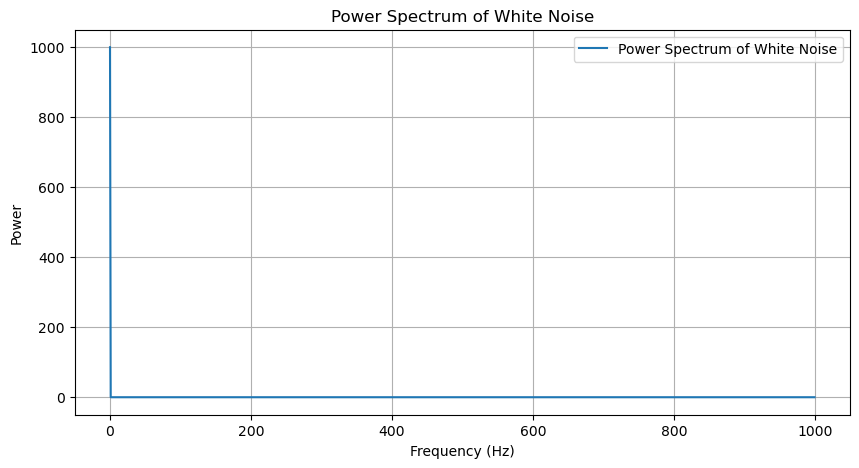

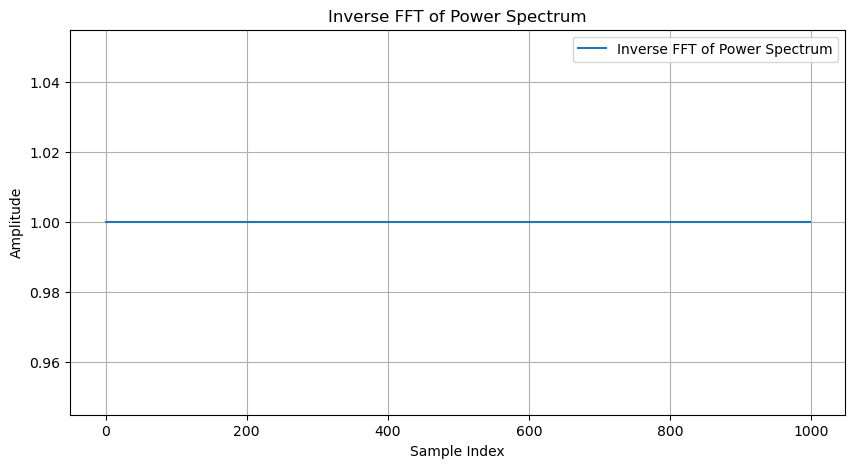

Normalization Factor: 1.0


In [6]:
white_noise = np.ones(1000)

ps = np.fft.fft(white_noise)
ps = np.abs(ps) ** 2
ps = ps / len(ps)

plt.figure(figsize=(10, 5))
plt.plot(ps, label="Power Spectrum of White Noise")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum of White Noise")
plt.legend()
plt.grid()
plt.show()

noise = np.fft.ifft(ps)
noise = noise[1:]
plt.figure(figsize=(10, 5))
plt.plot(noise.real, label="Inverse FFT of Power Spectrum")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("Inverse FFT of Power Spectrum")
plt.legend()
plt.grid()
plt.show()

print("Normalization Factor:", np.mean(noise.real) / np.mean(white_noise))

## Test Uncertainties

In [7]:
sampling_rate = 8  # Hz
timestep = 1 / sampling_rate  # Time step in seconds
f_nyq = sampling_rate / 2  # Nyquist frequency
f_min = 1 / (timestep * len(rpN_data[0]))  # Minimum frequency

# Frequencies for the power spectrum
freqs = np.linspace(f_min, f_nyq, 20000)

In [8]:
sigma2 = np.empty((3, len(data_names)))
std_data = np.empty((3, len(data_names)))
config_indices = [12, 3, 37]

for iconfig, config_index in enumerate(config_indices):
    print(f"\nConfiguration Index: {config_index}")
    print("=" * 60)
    for i, data_name in enumerate(data_names):
        A_white = dict_fit["values"][data_name]["A_white"][config_index]
        f_knee = dict_fit["values"][data_name]["f_knee"][config_index]
        alpha = dict_fit["values"][data_name]["alpha"][config_index]

        # Power spectrum calculation
        S = A_white**2 * (1 + np.abs(f_knee / freqs) ** alpha)
        # Integrate
        sigma2_val = np.trapz(S, freqs)
        std_val = np.sqrt(sigma2_val)

        if data_name in ["rpN", "rpE", "rpD"]:
            unit = "m"
        elif data_name in ["roll", "yaw"]:
            unit = "deg"
        else:
            unit = "unknown"

        sigma2[iconfig, i] = sigma2_val
        std_data[iconfig, i] = dict_fit['standard_deviation'][data_name][config_index] / 100

        print(f"{data_name:>6} | std (PS) = {std_val:.4e} {unit} | std = {std_data[iconfig, i]:.4e} {unit}")

    print("=" * 60)


Configuration Index: 12
   rpN | std (PS) = 1.7750e-02 m | std = 3.0020e-03 m
   rpE | std (PS) = 7.1335e-03 m | std = 1.7864e-03 m
   rpD | std (PS) = 1.3220e-02 m | std = 2.1307e-03 m
  roll | std (PS) = 6.3821e-03 deg | std = 5.9903e-04 deg
   yaw | std (PS) = 7.1491e-03 deg | std = 8.1497e-04 deg

Configuration Index: 3
   rpN | std (PS) = 1.2603e-02 m | std = 4.6857e-03 m
   rpE | std (PS) = 1.0334e-02 m | std = 2.5729e-03 m
   rpD | std (PS) = 1.9451e-02 m | std = 3.6566e-03 m
  roll | std (PS) = 4.1692e-03 deg | std = 9.9899e-04 deg
   yaw | std (PS) = 9.3150e-03 deg | std = 2.2937e-03 deg

Configuration Index: 37
   rpN | std (PS) = 1.5409e-02 m | std = 5.2996e-03 m
   rpE | std (PS) = 1.1949e-02 m | std = 5.5120e-03 m
   rpD | std (PS) = 1.7427e-02 m | std = 2.8445e-03 m
  roll | std (PS) = 7.9130e-03 deg | std = 4.3201e-03 deg
   yaw | std (PS) = 1.7759e-02 deg | std = 4.1674e-03 deg


In [9]:
sigma_ps_pos = np.sqrt(np.sum(sigma2[:3]))
sigma_ps_ang = np.sqrt(np.sum(sigma2[3:]))

print(f"Uncertainty for antenna 1 position at config {config_index}: {sigma_ps_pos * 100:.3f} cm")
print(f"Uncertainty for antenna 2 angle at config {config_index}: {np.degrees(sigma_ps_ang):.3f} deg")

Uncertainty for antenna 1 position at config 37: 4.942 cm
Uncertainty for antenna 2 angle at config 37: 0.000 deg


# Calibration Source Beam from position and orientation uncertainties 

For this work, we don't want to perform accurate estimation but only order of magnitude.
So, we will assume that the two antennas are perfectly aligned with the calibration source's line-of-sight, which is pointing exactly at the center of QUBIC, and considering that the system GPS + Calibration Source is perfectly fixed together.

Under these hypotheses:
* The uncertainty on the calibration source position is the uncertainty on the antenna 1,
* The uncertainty on the angels between antennas 1 & 2 is the uncertainty on the calibration source orientation.

In [10]:
qubic_height = 4  # m
calsource_height = 48.6  # m
ground_distance = 38.44  # m

distance_qubic_calsource = np.sqrt((calsource_height - qubic_height) ** 2 + ground_distance**2)

print(f"Distance between QUBIC and calibration source: {distance_qubic_calsource:.2f} m")

Distance between QUBIC and calibration source: 58.88 m


## Gaussian Beam

Spot size : $w(z) = w_0 \sqrt{1 + (z/z_R)^2}$, where $z_R = \pi w_0^2 n / \lambda \\$

Gaussian Beam Intensity : $\\$
$I(r, z) = I_0 (\frac{w_0}{w(z)})^2 exp(-\frac{2r^2}{w^2(z)})$

In [11]:
def gaussian_beam(r, z, w0, I0=1.0):
    """
    Calculate the Gaussian beam intensity at a distance r from the center
    and at a distance z from the beam waist.

    Parameters:
    r : radial distance from the center (m)
    z : distance from the beam waist (m)
    w0 : beam waist radius (m)
    I0 : peak intensity at the beam waist (W/m²)

    Returns:
    I : intensity at distance r and z (W/m²)
    """
    z_R = np.pi * w0**2 / c  # Rayleigh range
    w_z = w0 * np.sqrt(1 + (z / z_R) ** 2)  # Beam radius at distance z
    return I0 * (w0 / w_z) ** 2 * np.exp(-2 * r**2 / w_z**2)

In [12]:
freq = 150e9  # Frequency in Hz
wavelength = c / freq  # Wavelength in meters
FWHM = 13  # degrees
FWHM_rad = np.radians(FWHM)

# Calculate the beam waist radius w0
theta_0 = FWHM_rad / (2 * np.sqrt(2 * np.log(2)))
w0 = wavelength / (np.pi * theta_0)
print(f"Beam waist radius w0 = {w0:.3f} m")

Beam waist radius w0 = 0.007 m


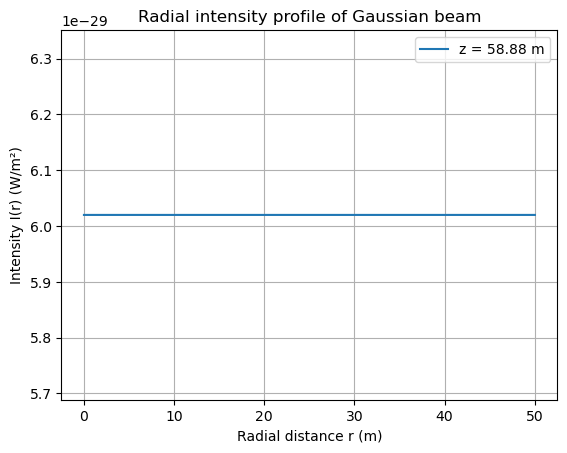

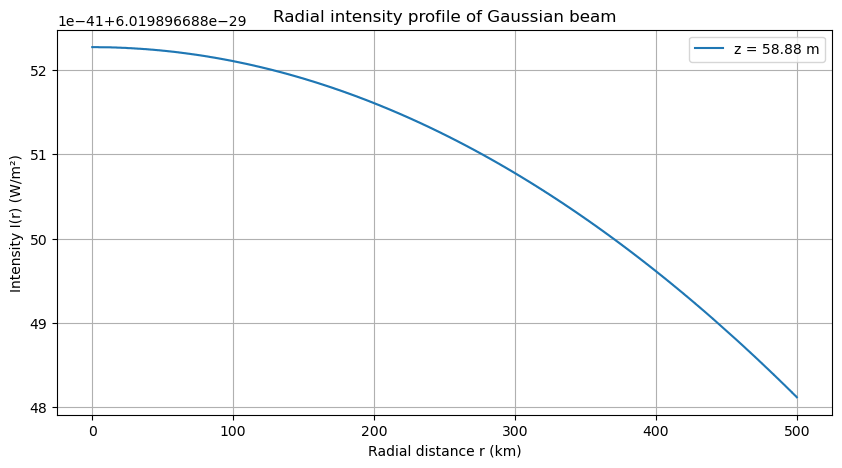

In [13]:
r = np.linspace(1e-3, 50, 10000)
z = distance_qubic_calsource.round(2)  # Distance from the beam waist
I0 = 1.0

beam = gaussian_beam(r, z, w0, I0)

plt.figure()
plt.plot(r, beam, label=f"z = {z} m")
plt.xlabel("Radial distance r (m)")
plt.ylabel("Intensity I(r) (W/m²)")
plt.title("Radial intensity profile of Gaussian beam")
plt.legend()
plt.grid()
plt.show()

r = np.linspace(1e-3, 500000, 10000)

beam = gaussian_beam(r, z, w0, I0)

plt.figure(figsize=(10, 5))
plt.plot(r / 1000, beam, label=f"z = {z} m")
plt.xlabel("Radial distance r (km)")
plt.ylabel("Intensity I(r) (W/m²)")
plt.title("Radial intensity profile of Gaussian beam")
plt.legend()
plt.grid()
plt.show()

## Modification of the beam due to Calsource uncertainties

In [14]:
N = 1000000

mu = np.zeros(len(data_names))  # Mean vector for position uncertainties

cov = np.empty((3, len(data_names), len(data_names)))  # Covariance matrix for position uncertainties
samples = np.empty((3, N, len(data_names)))  # Samples for position uncertainties
for i in range(3): 
    cov[i] = sigma2[i] * np.eye(len(data_names))  # Covariance matrix for each data name
    samples[i] = np.random.multivariate_normal(mu, cov[i], N)

amplitudes = np.empty(N)

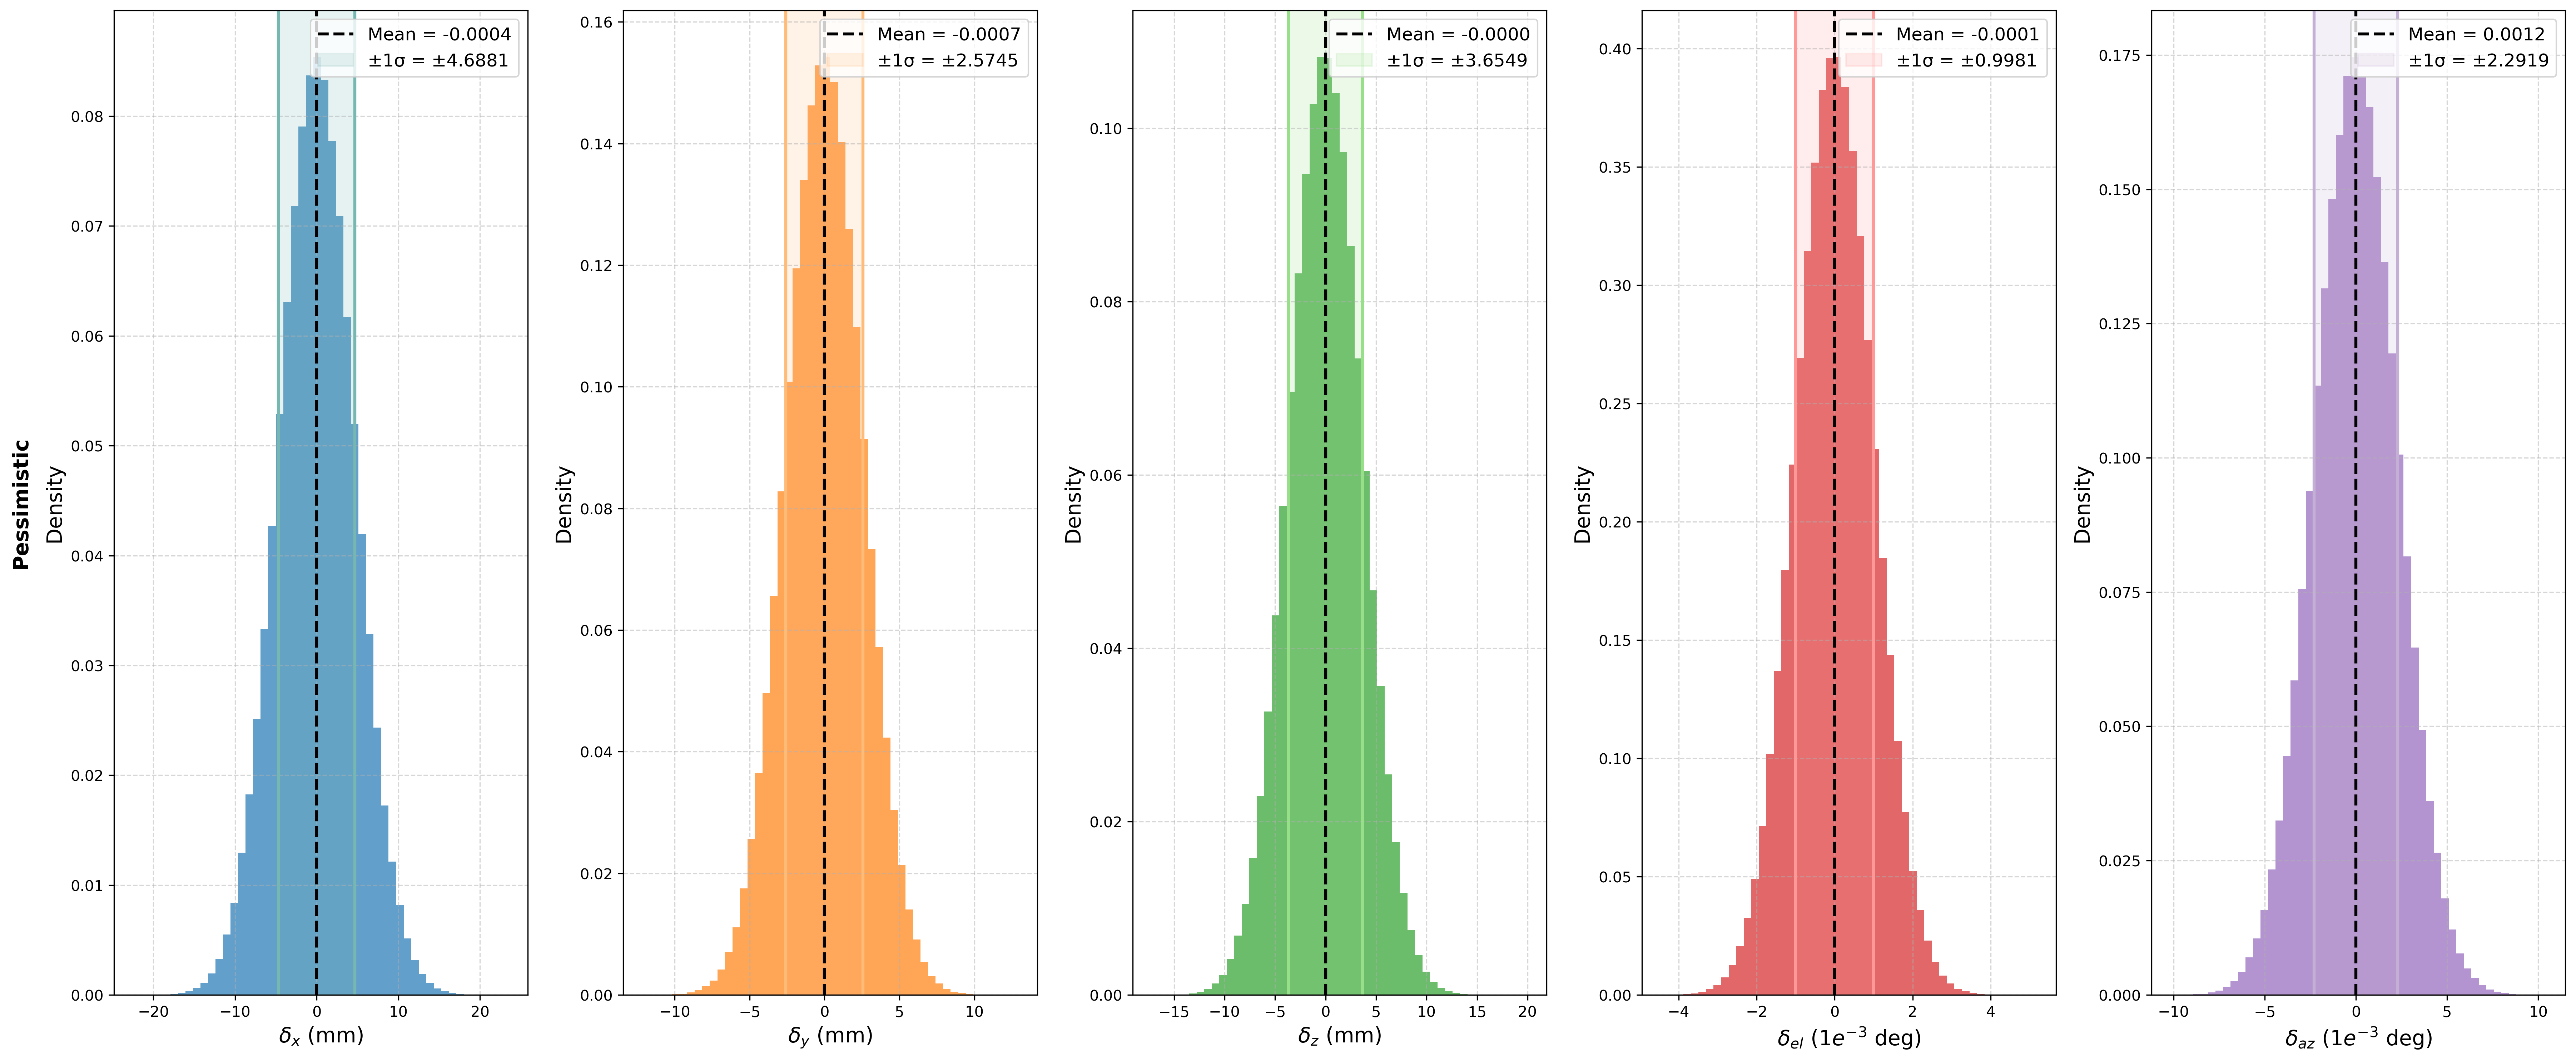

In [27]:
# Plot the marginal distributions of X, Y, Z, el, az samples for each configuration in a (3, 5) subplot
labels = [r"$\delta_x$ (mm)", r"$\delta_y$ (mm)", r"$\delta_z$ (mm)", r"$\delta_{el}$ ($1e^{-3}$ deg)", r"$\delta_{az}$ ($1e^{-3}$ deg)"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
sigma_colors = ["#76b7b2", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5"]
name_config = ["Optimistic", "Realistic", "Pessimistic"]

all_samples = []

config_index = 1  # Use the second configuration index for the example

stds = std_data[config_index] * 1e3 # Get the standard deviations for the selected configuration
cov = np.diag(np.array(stds)**2)
samples = np.random.multivariate_normal(np.zeros(5), cov, N)
all_samples.append(samples)

fig, axes = plt.subplots(1, 5, figsize=(24, 10), dpi=300)
for i in range(5):
    ax = axes[i]
    data = samples[:, i]
    mean = np.mean(data)
    std = np.std(data)
    ax.hist(data, bins=50, color=colors[i], alpha=0.7, density=True)
    ax.axvline(mean, linestyle="--", color="k", linewidth=2, label=f"Mean = {mean:.4f}")
    ax.axvline(mean + std, linestyle="-", color=sigma_colors[i], linewidth=2)
    ax.axvline(mean - std, linestyle="-", color=sigma_colors[i], linewidth=2)
    ax.axvspan(mean - std, mean + std, color=sigma_colors[i], alpha=0.18, label=f"±1σ = ±{std:.4f}")
    ax.set_xlabel(labels[i], fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    if iconfig == 0:
        ax.set_title(labels[i], fontsize=14)
    if i == 0:
        ax.annotate(name_config[iconfig], xy=(-0.2, 0.5), xycoords='axes fraction', fontsize=14,
                    ha='right', va='center', rotation=90, fontweight='bold')
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()

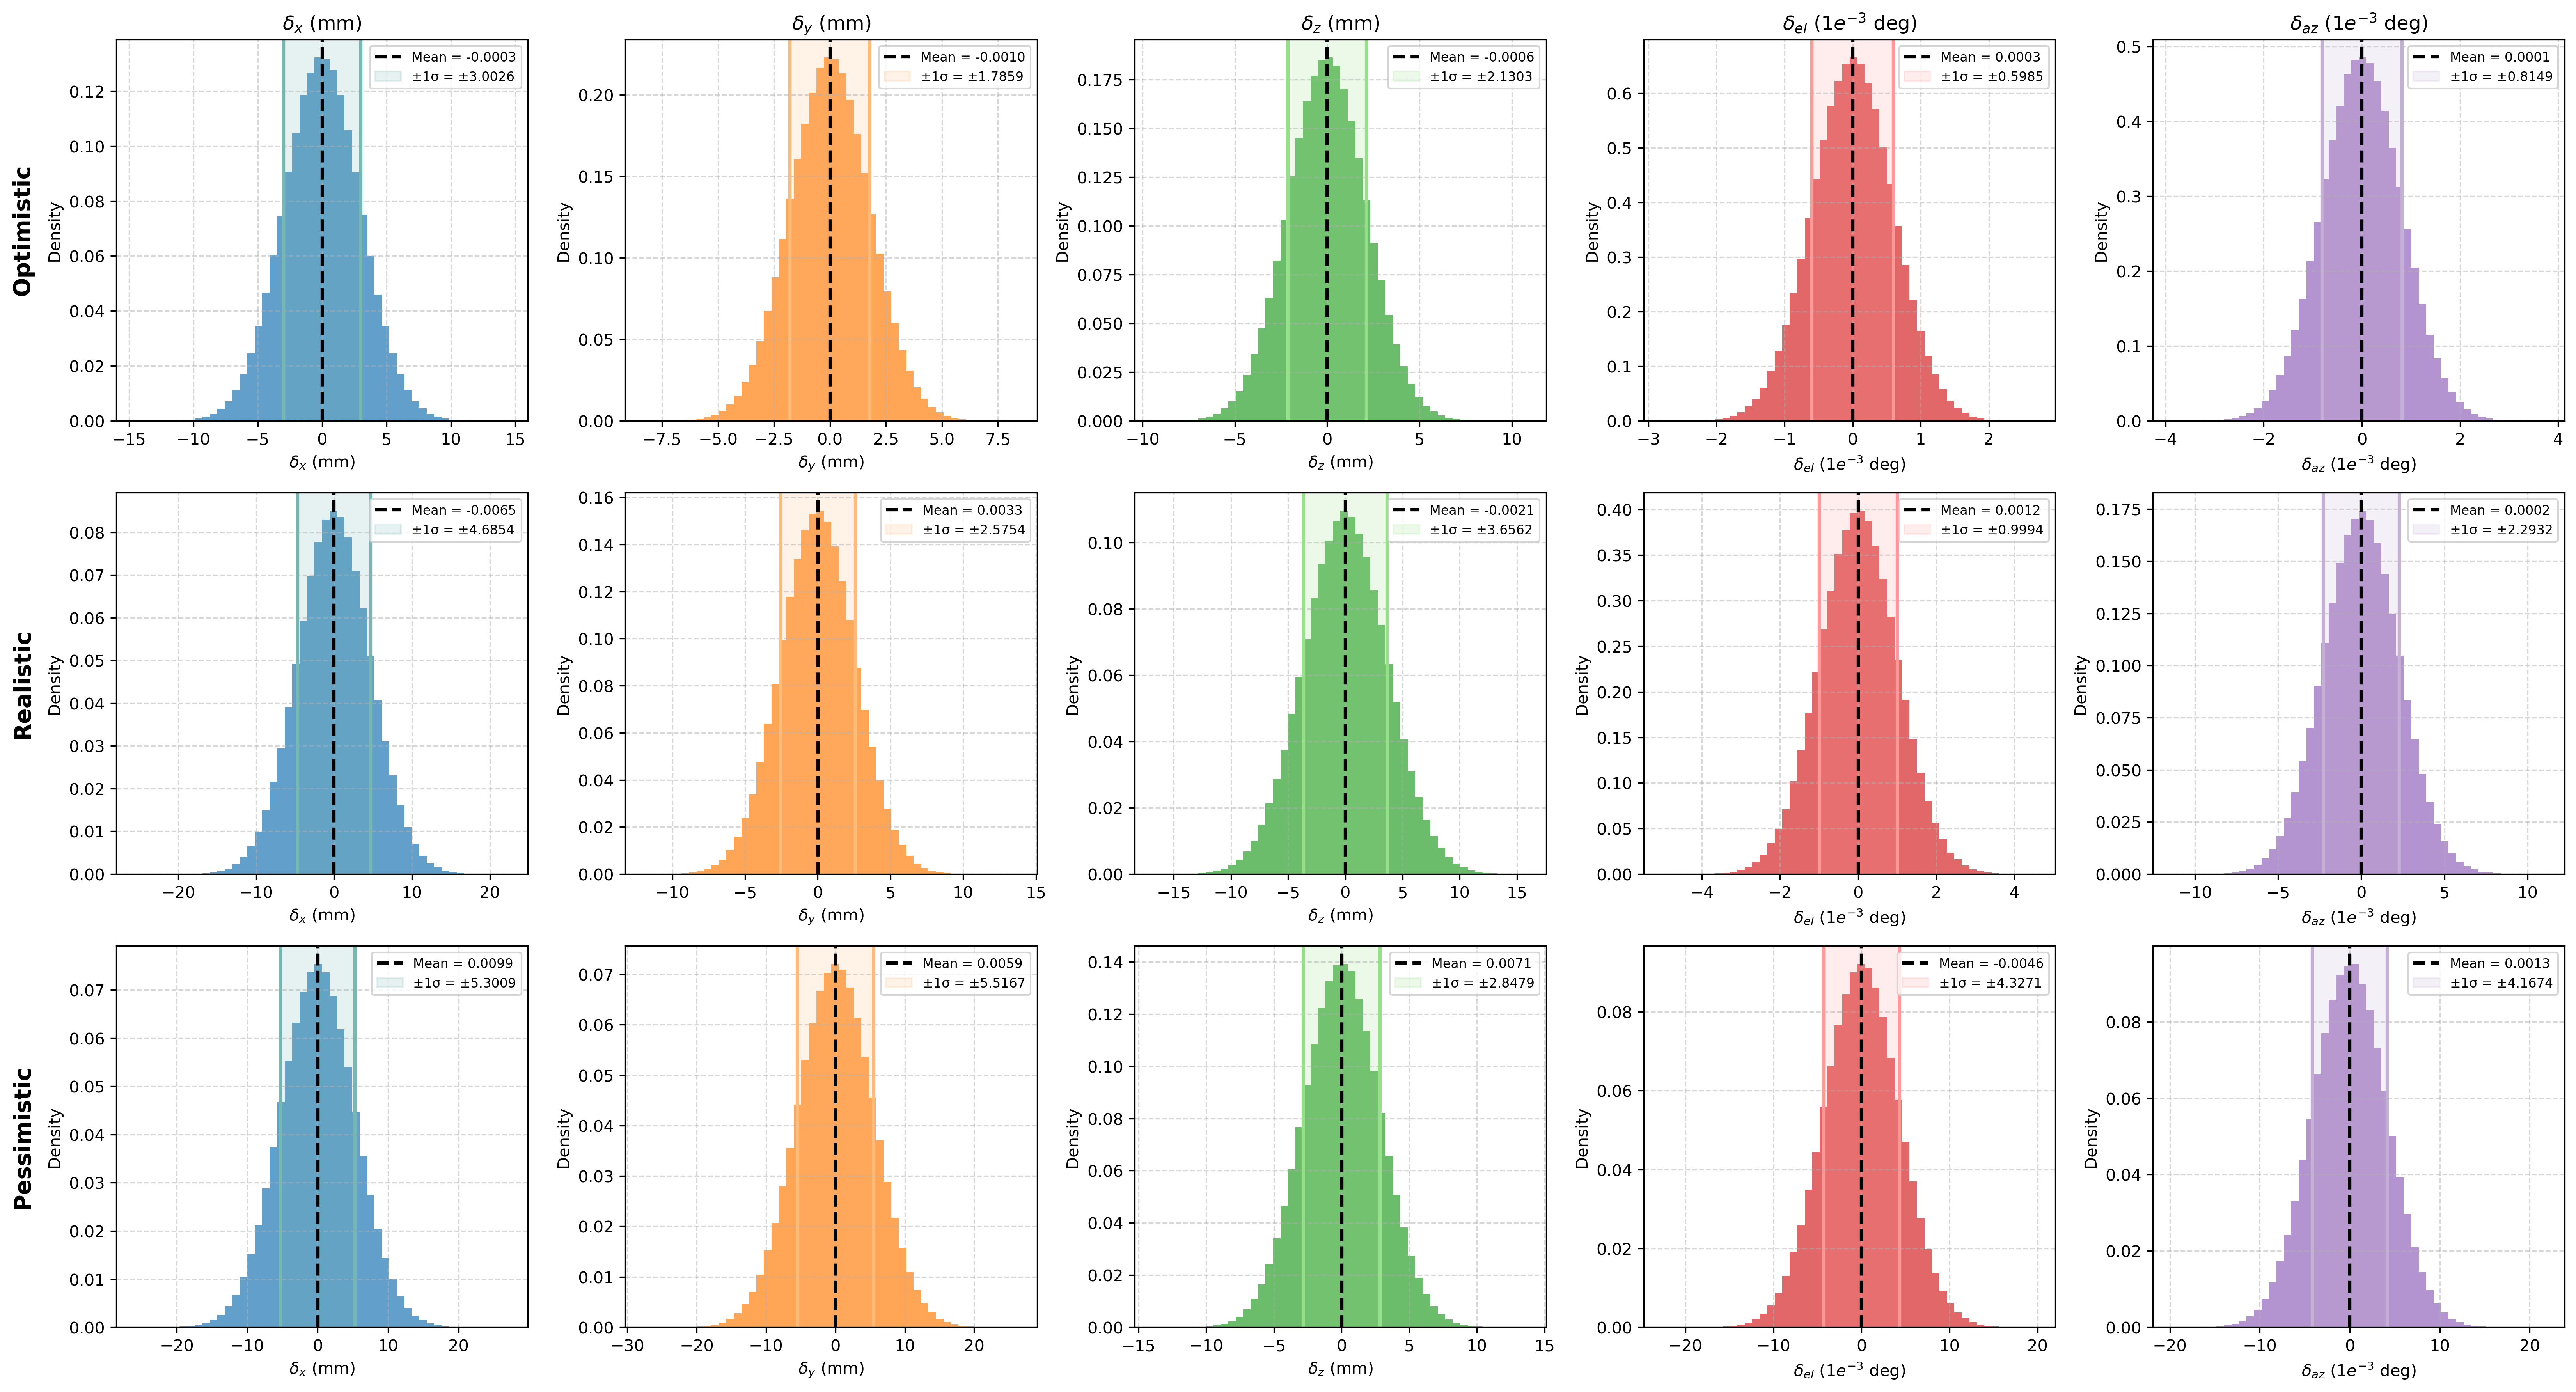

In [16]:
# Plot the marginal distributions of X, Y, Z, el, az samples for each configuration in a (3, 5) subplot

all_samples = []

for iconfig, config_index in enumerate(config_indices):
    stds = std_data[iconfig] * 1e3 # Get the standard deviations for the selected configuration
    cov = np.diag(np.array(stds)**2)
    samples = np.random.multivariate_normal(np.zeros(5), cov, N)
    all_samples.append(samples)

fig, axes = plt.subplots(3, 5, figsize=(22, 12), dpi=300)
for iconfig, samples in enumerate(all_samples):
    for i in range(5):
        ax = axes[iconfig, i]
        data = samples[:, i]
        mean = np.mean(data)
        std = np.std(data)
        ax.hist(data, bins=50, color=colors[i], alpha=0.7, density=True)
        ax.axvline(mean, linestyle="--", color="k", linewidth=2, label=f"Mean = {mean:.4f}")
        ax.axvline(mean + std, linestyle="-", color=sigma_colors[i], linewidth=2)
        ax.axvline(mean - std, linestyle="-", color=sigma_colors[i], linewidth=2)
        ax.axvspan(mean - std, mean + std, color=sigma_colors[i], alpha=0.18, label=f"±1σ = ±{std:.4f}")
        ax.set_xlabel(labels[i])
        ax.set_ylabel("Density")
        if iconfig == 0:
            ax.set_title(labels[i])
        if i == 0:
            ax.annotate(name_config[iconfig], xy=(-0.2, 0.5), xycoords='axes fraction', fontsize=14,
                        ha='right', va='center', rotation=90, fontweight='bold')
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend(fontsize=8, loc="upper right")
plt.tight_layout()
plt.show()

### 1. **Physical Context and Coordinate System**

- The calibration source emits a beam toward the QUBIC receiver.
- The **x-axis** is defined along the line joining the source and QUBIC (beam axis).
- The **z-axis** is vertical (upwards).
- The **y-axis** is horizontal and orthogonal to both x and z.

In this frame:
- **Azimuth (`az`)** is a rotation around the z-axis (vertical), causing the beam to sweep left-right (modifies y).
- **Elevation (`el`)** is a rotation around the y-axis (horizontal), causing the beam to sweep up-down (modifies z).

### 2. **Uncertainties**

- The calibration source position is uncertain in all three spatial directions: `d_x`, `d_y`, `d_z`.
- The orientation is also uncertain: `d_el` (elevation), `d_az` (azimuth).
- These uncertainties are sampled from a multivariate normal distribution.

### 3. **Propagation of Uncertainties**

#### **a. QUBIC Position Vector**

We define the QUBIC position in the source frame as:
```python
qubic_vec = np.array([distance_qubic_calsource, 0, 0])
```
This means QUBIC is located at a distance `distance_qubic_calsource` along the x-axis from the source.

#### **b. Applying Rotations**

To account for orientation uncertainties, we rotate the QUBIC vector by the sampled elevation and azimuth angles:

- **Elevation rotation (`R_el`)**: Rotates around the y-axis.
- **Azimuth rotation (`R_az`)**: Rotates around the z-axis.

The combined rotation is:
```python
R = R_az @ R_el
qubic_rot = R @ qubic_vec
```
This gives the new direction of the beam after applying the sampled orientation errors.

#### **c. Adding Position Uncertainties**

After rotation, we add the sampled position uncertainties:
```python
qubic_rot += np.array([d_x, d_y, d_z])
```
This shifts the QUBIC position according to the sampled errors.

#### **d. Calculating the Offset from the Beam Axis**

The **radial offset** from the beam axis (which is now possibly misaligned) is:
```python
delta_r = np.sqrt(qubic_rot[1]**2 + qubic_rot[2]**2)
```
This is the distance from the beam axis in the y-z plane.

The **longitudinal offset** (distance along the beam axis) is:
```python
delta_x = qubic_rot[0]
```
This is the new distance from the source along the (possibly rotated) x-axis.

#### **e. Calculating the Received Intensity**

The received intensity at QUBIC is then computed using the Gaussian beam formula:
```python
amplitudes[i] = gaussian_beam(delta_r, delta_x, w0, I0) / intensity_normalization
```
- `gaussian_beam(r, z, w0, I0)` gives the intensity at radial offset `r` and distance `z` from the source.
- We normalize by the intensity at the nominal position to get a relative amplitude.

In [17]:
normalization_beam = gaussian_beam(0, distance_qubic_calsource, w0, I0)

amplitudes_all = []
labels_conf = []

for iconfig, config_index in enumerate(config_indices):
    # Get uncertainties for this configuration
    stds = std_data[iconfig]

    # Build covariance (diagonal, uncorrelated)
    cov = np.diag(np.array(stds)**2)    

    # Draw samples
    samples = np.random.multivariate_normal(np.zeros(5), cov, N)

    # Compute amplitudes
    amplitudes = np.empty(N)
    for i, (d_x, d_y, d_z, d_el, d_az) in enumerate(samples):
        el_rad = np.radians(d_el)
        az_rad = np.radians(d_az)

        R_el = np.array([[np.cos(el_rad), 0, np.sin(el_rad)],
                        [0, 1, 0],
                        [-np.sin(el_rad), 0, np.cos(el_rad)]])
        R_az = np.array([[np.cos(az_rad), -np.sin(az_rad), 0],
                        [np.sin(az_rad), np.cos(az_rad), 0],
                        [0, 0, 1]])
        R = R_az @ R_el
        qubic_vec = np.array([distance_qubic_calsource, 0, 0])
        qubic_rot = R @ qubic_vec + np.array([d_x, d_y, d_z])
        delta_r = np.sqrt(qubic_rot[1] ** 2 + qubic_rot[2] ** 2)
        delta_x = qubic_rot[0]
        amplitudes[i] = gaussian_beam(delta_r, delta_x, w0, I0) / normalization_beam

    amplitudes_all.append(amplitudes)
    labels_conf.append(f'Config {config_index}')

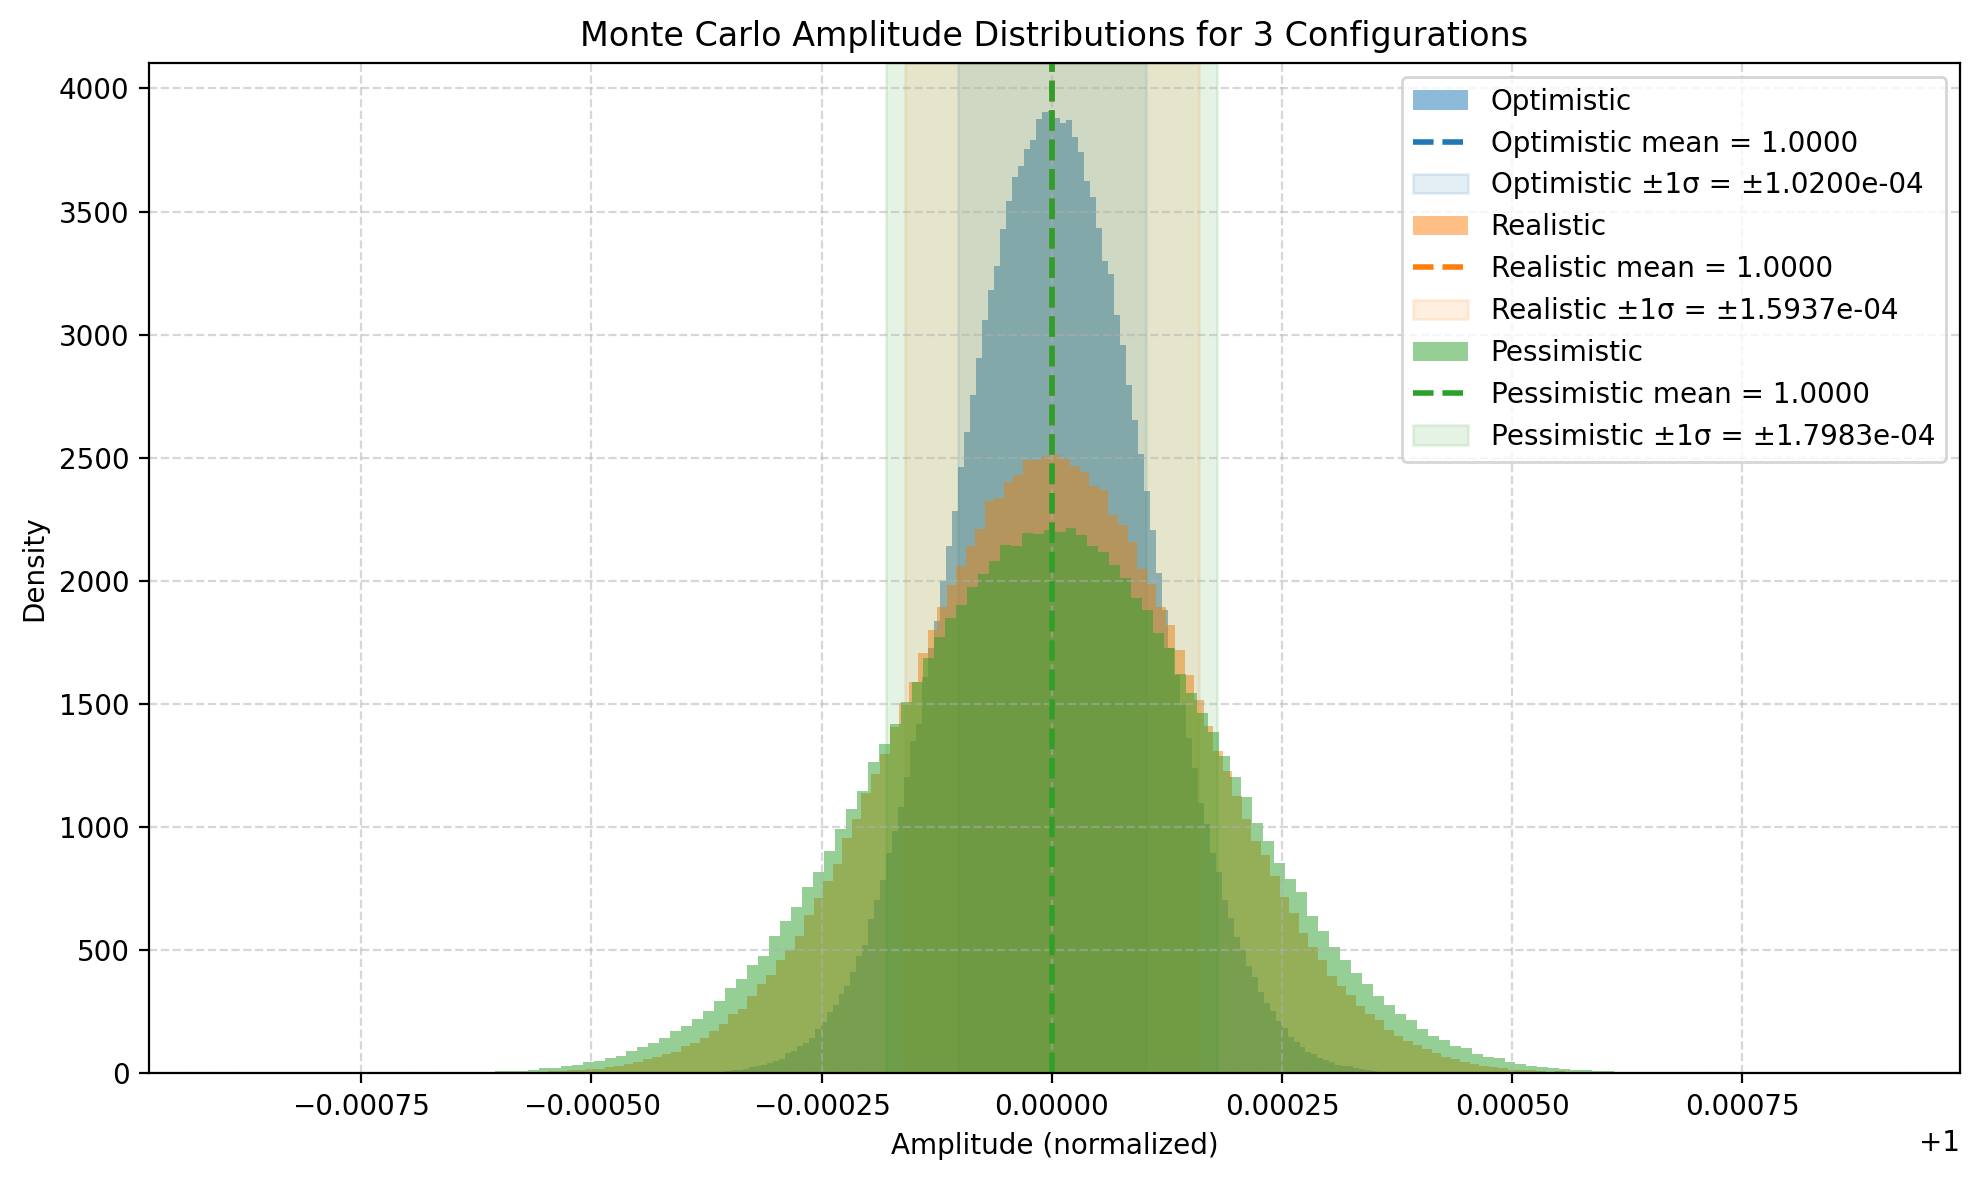

In [19]:
# Plot amplitude distributions for the 3 configurations
plt.figure(figsize=(10, 6), dpi=200)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, (amplitudes, label) in enumerate(zip(amplitudes_all, labels_conf)):
    plt.hist(amplitudes, bins=150, density=True, alpha=0.5, color=colors[i], label=name_config[i])
    mean = np.mean(amplitudes)
    std = np.std(amplitudes)
    plt.axvline(mean, color=colors[i], linestyle='--', linewidth=2, label=f'{name_config[i]} mean = {mean:.4f}')
    plt.axvspan(mean-std, mean+std, color=colors[i], alpha=0.12, label=f'{name_config[i]} ±1σ = ±{std:.4e}')

plt.xlabel('Amplitude (normalized)')
plt.ylabel('Density')
plt.title('Monte Carlo Amplitude Distributions for 3 Configurations')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()